In [1]:
import sys
print(sys.executable)

D:\Anaconda\envs\py39\python.exe


In [2]:
import math
from d2l import torch as d2l
import torch
import jieba
from sklearn.model_selection import train_test_split
import torch.nn as nn
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [3]:
def read_comments(comment_path,mode=False):
    with open(comment_path,'r',encoding='utf-8') as fp:
        #第一行是数据指标标签，不要，最后一行是一个空格，不要
        raw_data = fp.read().split('\n')[1:-1]
        #每一行数据，第一个字符是标签，后续字符是评论内容
        comments = [raw_data[i][2:] for i in range(len(raw_data))]
        lables = torch.tensor([int(raw_data[i][0]) for i in range(len(raw_data))])
        #对评论进行分词,cut_all为分词模式
        comments = [[i for i in jieba.cut(comment,cut_all=mode)]for comment in comments]
        #返回分词后的评论和对应的评分
    return comments,lables

In [4]:
comments_path = r'E:\computer\database\weibo_senti_100k\weibo_senti_100k.csv'
comments,lables = read_comments(comments_path)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Xiaochen\AppData\Local\Temp\jieba.cache
Loading model cost 0.387 seconds.
Prefix dict has been built successfully.


In [6]:
comments[235]

['#',
 '深玩',
 '美国',
 '#',
 '西雅图',
 '中央',
 '图书馆',
 '，',
 '库',
 '哈斯',
 '设计',
 '。',
 '这',
 '家伙',
 '也',
 '设计',
 '了',
 '咱们',
 '北京',
 '的',
 '那个',
 '大',
 '裤衩',
 '[',
 '哈哈',
 ']',
 '典型',
 '的',
 '“',
 '解构',
 '”',
 '建筑',
 '说白了',
 '就是',
 '设计',
 '突破',
 '了',
 '以往',
 '以',
 '“',
 '藏书',
 '”',
 '为',
 '中心',
 '的',
 '图书馆',
 '空间',
 '，',
 '而是',
 '为',
 '大家',
 '交流',
 '营造',
 '丰富',
 '的',
 '空间',
 '，',
 '10',
 '层',
 '有',
 '个',
 '观景',
 '处',
 '，',
 '往下',
 '看',
 '晕',
 '不',
 '晕',
 '就',
 '看',
 '你',
 '自己',
 '了',
 '[',
 '偷笑',
 ']',
 '@',
 '玩乐',
 '美国',
 ' ',
 '@',
 '美国',
 '旅游',
 '玩乐',
 '汇']

In [7]:
def process_data(comment_path,batch_size,max_len,min_freq):
    """返回数据迭代器和评论数据集的词表"""
    #把评论和对应的评分取出来
    comments,labels = read_comments(comment_path)
    #创建vocab，使得每个词都有对应的索引，将词频小于min_freq的词不要了，不然这个vocab太大了
    vocab = d2l.Vocab(comments, min_freq=min_freq)
    #划分训练集和测试集
    train_comment, test_comment, train_label, test_label = train_test_split(comments,labels,test_size=0.3,random_state=26,shuffle=True)
    #鉴于绝大部分评论都在max_len个词以下，把每一条评论都处理成相同长度（max_len个词），对短评论进行填充'<unk>',对长评论进行截断
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[comment], max_len, vocab['<unk>']) for comment in train_comment])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[comment], max_len, vocab['<unk>']) for comment in test_comment])
    #返回数据迭代器
    train_iter = d2l.load_array((train_features,train_label),
                                batch_size)
    test_iter = d2l.load_array((test_features,test_label),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab

In [14]:
class TokenEmbedding:

    def __init__(self, file_path):

        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            file_path)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, file_path):
        idx_to_token, idx_to_vec = ['<unk>'], []

        with open(file_path, 'r', encoding='utf-8') as fp:
            
            word_vecs = fp.readlines()
        word_vecs = [i for i in word_vecs][1:] #第一行信息没啥用，所以不要了
        for vec in word_vecs:
            #消除每一行后面的‘\n’,已经后面多余空格，然后依据空格划分元素，形成一个列表
            elems = vec.rstrip().rstrip('\n').split(' ')
            #每一行的第一个元素是词，剩余的元素是词向量
            token,elems = elems[0],[float(elem) for elem in elems[1:]]
            idx_to_token.append(token)
            idx_to_vec.append(elems)

        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, d2l.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[d2l.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

In [9]:
class AddNorm(nn.Module):
    """
    Transformer架构里面的Add & Norm layer.
    """
    def __init__(self, normalized_shape, dropout, eps=1e-5):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape, eps=eps)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

class PositionWiseFFN(nn.Module):
    """
    FFN
    """
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs):
        super(PositionWiseFFN, self).__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

class TransformerBlock(nn.Module):
    """
    Transformer encoder block.
    """
    def __init__(self, embed_dim, num_heads, ffn_hidden, dropout):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout)
        self.addnorm1 = AddNorm(embed_dim, dropout)
        self.ffn = PositionWiseFFN(embed_dim, ffn_hidden, embed_dim)
        self.addnorm2 = AddNorm(embed_dim, dropout)

    def forward(self, X):
        Y = self.addnorm1(X, self.attention(X, X, X, need_weights=False)[0])
        return self.addnorm2(Y, self.ffn(Y))

In [10]:
class semi_bert(nn.Module):
    def __init__(self, vocab_size, embed_size, ffn_hiddens, num_heads,num_blks, dropout, max_len=80, **kwargs):
        super(semi_bert, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, embed_size)
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                          embed_size)*0.01)
        self.blks = nn.Sequential()

        for i in range(num_blks):
            self.blks.add_module(f"{i}", TransformerBlock(
                embed_dim=embed_size, num_heads=num_heads, ffn_hidden=ffn_hiddens, dropout=dropout))
        self.output = nn.Linear(embed_size, 2)

    def forward(self, tokens):

        # X的shape：(batch size, max_length,num_hiddens)
        X = self.token_embedding(tokens) + self.pos_embedding
        for blk in self.blks:
            X = blk(X)
        #获取句子的平均表示，而不是提取第一个字符
        X = self.output(torch.mean(X, dim=1))
        return X

In [11]:
def train_one_epoch(net, X, y, loss, trainer, device):

    if isinstance(X, list):
        X = [x.to(device) for x in X]
    else:
        X = X.to(device)

    y = y.to(device)
    net.train()
    trainer.zero_grad()
    pred = net(X)

    l = loss(pred, y)
    l.mean().backward()
    trainer.step()

    train_loss_sum = l.sum()

    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

In [12]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,device=d2l.try_gpu()):

    #权重初始化
    def initialize_weights(model):
        for name, param in model.named_parameters():
            if name.startswith('token_embedding'):
                continue  # 跳过词嵌入层

            # 处理 TransformerBlock 中的层
            if isinstance(param, nn.Linear):
                if 'attention' in name:
                    # 多头注意力层的线性层
                    nn.init.xavier_uniform_(param.weight)
                else:
                    # FFN 中的线性层
                    nn.init.kaiming_uniform_(param.weight, a=math.sqrt(5))
                if param.bias is not None:
                    fan_in, _ = nn.init._calculate_fan_in_and_fan_out(param.weight)
                    bound = 1 / math.sqrt(fan_in)
                    nn.init.uniform_(param.bias, -bound, bound)
            elif isinstance(param, nn.LayerNorm):
                nn.init.ones_(param.weight)
                nn.init.zeros_(param.bias)

    net.apply(initialize_weights)

    #将预训练好的词嵌入加载到net的embeding层里，并且不进行梯度回传
    #当然，你也可以进行训练
    net.token_embedding.weight.data.copy_(embeds)
    net.token_embedding.weight.requires_grad = False


    num_batches = len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net.to(device)
    for epoch in range(num_epochs):
        #定义一个容器，里面存放着训练损失，训练准确度，样本数量
        metric = d2l.Accumulator(3)
        for i, (features, labels) in enumerate(train_iter):


            l, acc = train_one_epoch(net, features, labels, loss, trainer, device)

            metric.add(l, acc, labels.shape[0])

            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[2],
                              None))

        #查看测试集的准确率
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))

    print(f'平均损失: {metric[0] / metric[2]:.3f}, 训练准确度: '
          f'{metric[1] / metric[2]:.3f}, 测试准确度: {test_acc:.3f}')


In [21]:
batch_size = 512                                   #批量大小
lr = 0.0003                                        #学习率
num_epochs = 30                                    #训练几轮
embed_size = 200                                   #词嵌入维度，我选了200维的
ffn_hiddens = 64                                   #FFN，隐藏层单元数量
num_heads = 4                                      #注意力头的个数
num_blks = 1                                       #transformer_block的个数
dropout = 0.5                                      #dropout率（用于正则化）
max_len = 50                                       #每个句子的最大长度
min_freq = 3                                       #最小词频阈值
devices = d2l.try_gpu()                            #设备

embedding_path = r'E:\computer\database\1000000-small.txt'  #词向量的位置
comment_path = r'E:\computer\database\weibo_senti_100k\weibo_senti_100k.csv'              #数据集的位置

train_iter, test_iter, vocab = process_data(comment_path,batch_size,max_len=max_len,min_freq = min_freq)

my_embedding = TokenEmbedding(embedding_path)
embeds = my_embedding[vocab.idx_to_token]          #把词向量和我的vocab结合起来

In [22]:
print(embeds.shape)

torch.Size([68169, 200])


In [23]:
net = semi_bert(len(vocab), embed_size, ffn_hiddens, num_heads,num_blks,dropout,max_len)  #定义网络
trainer = torch.optim.Adam(net.parameters(), lr=0.0003,weight_decay=1e-4)     #优化器，使用Adam
loss = nn.CrossEntropyLoss(reduction="none")     #损失函数

平均损失: 0.197, 训练准确度: 0.939, 测试准确度: 0.933


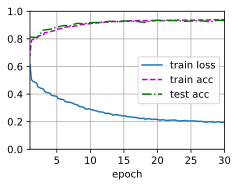

In [24]:
train(net, train_iter, test_iter, loss, trainer,num_epochs,d2l.try_gpu())

In [25]:
lable_map = ['负向评论','正向评论']
def predict(net, vocab, comment):
    '''
    对单个句子进行情感分析
    '''
    net.to(d2l.try_gpu())
    net.eval()
    comment = vocab[[i for i in jieba.cut(comment,cut_all=False)]]
    #将句子进行分词
    comment_pt = torch.tensor(d2l.truncate_pad(comment, max_len, vocab['<unk>']), device=d2l.try_gpu())
    label = torch.argmax(net(comment_pt.reshape(1, -1)), dim=1)
    return '该句子的情感是：' + lable_map[label]

In [67]:
predict(net, vocab, '神经病')

'该句子的情感是：负向评论'

In [61]:
import chardet
def predict_doc_visualize(net,vocab,test_path,out = False,draw = False):
    '''
    test_path：你的csv文件路径，注意：每条评论需要在第一列
    对一个文档的句子进行情感分析，并绘制词云
    out参数指明需不需要将句子和对应的情感输出出来
    draw参数指明需不需要绘制词云
    '''
    net.to(d2l.try_gpu())
    net.eval()
    
       # 检测文件编码
    with open(test_path, 'rb') as f:
        result = chardet.detect(f.read())  # 读取文件并检测编码
    encoding = result['encoding']
    print(encoding)
    
    with open(test_path,'r',encoding=encoding, errors='ignore') as fp:
        raw_data = fp.read().split('\n')[:-1]

        comments = [raw_data[i] for i in range(len(raw_data))]
        #对评论进行分词,cut_all为分词模式
        commentss = [vocab[[i for i in jieba.cut(j,cut_all=False)]] for j in comments]
        comment_pt = [torch.tensor(d2l.truncate_pad(i, max_len, vocab['<unk>']), device=d2l.try_gpu()) for i in commentss]
        #预测出来的情感
        labels = [torch.argmax(net(i.reshape(1, -1)), dim=1) for i in comment_pt]

    def generate_wordcloud(comments, sentiment):
        text = " ".join(comments)

        #font_path是字体文件，需要自己下载
        wordcloud = WordCloud(background_color="white",font_path="E:\computer\database\字体家AI造字特隶\字体家AI造字特隶.ttf").generate(text)
        plt.figure(figsize=(8, 8), facecolor=None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad=0)
        plt.title(f"Word Cloud - {sentiment} Sentiment")
        plt.show()

    if draw:
         #正向评论
        positive_comments = []
        #负向评论
        negative_comments = []
        for i, label in enumerate(labels):
            if label == 1:
                positive_comments.append(comments[i])
            else:
                negative_comments.append(comments[i])
        generate_wordcloud(positive_comments, "Positive")
        generate_wordcloud(negative_comments, "Negative")



    if out:
        for i in range(len(comments)):
            print(comments[i])
            print('\n')
            print('*情感*--->'+lable_map[labels[i]])
            print('\n')
            print('--------------------------------------------------------')

utf-8


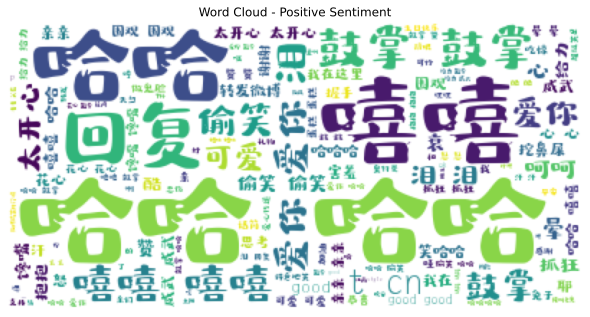

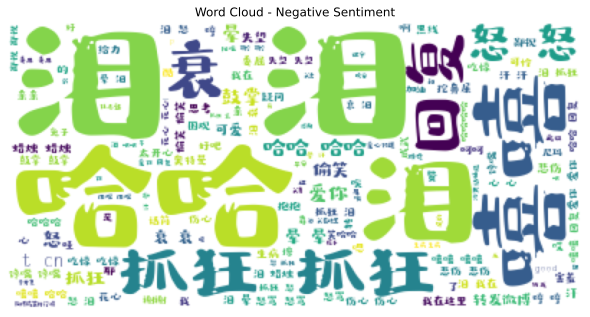

In [69]:
test_path = 'E:\computer\database\weibo_senti_100k\weibo_senti_100k.csv'
predict_doc_visualize(net,vocab,test_path,out = False,draw = True)